# 1. Sentiment

## a. Analysis

In [1]:
import pandas as pd
from transformers import pipeline

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv("../../Data Collection/Cakap Kids/cakap_kids_reviews_no_index.csv")
reviews = list(dataset["Reviews"])
reviews

['Tempatnya strategis, pengajarnya juga berkualitas. Ada permainan juga buat si kecil jd ga perlu takut karena si kecil ga akan bosan. Program kurikulumnya jg sangat membantu anak biar cepat paham. Sukses terus lah buat cakap',
 'Selain pengajarnya yg ramah, tempatnya jg nyaman buat anak2.. anak saya senang blajar dsni ',
 'Tempat belajar terfavorit dan pastinya nyaman banget anak2 sangat suka belajar disini ditambah lagi pengajar nya yg sangat sabar dan profesional ',
 'Tempat terbaik buat anak2 belajar bahasa inggris Fasilitas lengkap. Banyak aktivitasnya juga. Guru nya baik dan ramah Anak ku suka belajar disini',
 'Tempatnya bagus, Nyaman buat anak-anak belajar, Teacher nya baik dan ramah, Rekomendasi banget pokoknya, Sukses buat cakap kids academy',
 'Tempat nyaman banget, terus guru yang mengajar nya profesional, mantabbb lah cakap kids academy',
 'Asyik banget belajar di cakap kids academy tempatnya nyaman bersih menyenangkan sekali ',
 'Anak saya sangat senang belajar disini kar

In [3]:
def analyze_sentiment(text_to_analyze):
    # Specify the model and revision explicitly
    model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"

    # Load the sentiment analysis pipeline with explicit model
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model=model_name,
        tokenizer=model_name
    )

    # Perform sentiment analysis
    sentiment_result = sentiment_analyzer(text_to_analyze)

    return sentiment_result

In [4]:
sentiments = analyze_sentiment(reviews)

In [5]:
def get_df(sentences, sentiments):
    sents = {
        'review': sentences,
        'label': [senti['label'].upper() for senti in sentiments],
        'score': [senti['score'] for senti in sentiments]
    }

    df = pd.DataFrame(sents)
    return df

In [6]:
senti_df = get_df(reviews, sentiments)
senti_df.head()

,review,label,score
0,"Tempatnya strategis, pengajarnya juga berkuali...",POSITIVE,0.998759
1,"Selain pengajarnya yg ramah, tempatnya jg nyam...",POSITIVE,0.999244
2,Tempat belajar terfavorit dan pastinya nyaman ...,POSITIVE,0.999469
3,Tempat terbaik buat anak2 belajar bahasa inggr...,POSITIVE,0.999351
4,"Tempatnya bagus, Nyaman buat anak-anak belajar...",POSITIVE,0.999178


In [7]:
senti_df.to_csv("../../Data Analysis/Cakap Kids/cakap_kids_reviews_sentiment.csv", index=False)

## b. Visualization

In [8]:
import altair as alt
import matplotlib.pyplot as plt

### 1) sentiments distribution

In [9]:
def pie_chart(result, labels):
    plt.figure(figsize=(8, 8))
    plt.pie(result, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.show()

In [10]:
def show_bar_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(labels, counts, color=['#2394f7', '#f72323', '#fac343'])

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_xlabel('Sentimen')
    ax.set_ylabel('Jumlah')
    ax.set_title(title)

    plt.show()

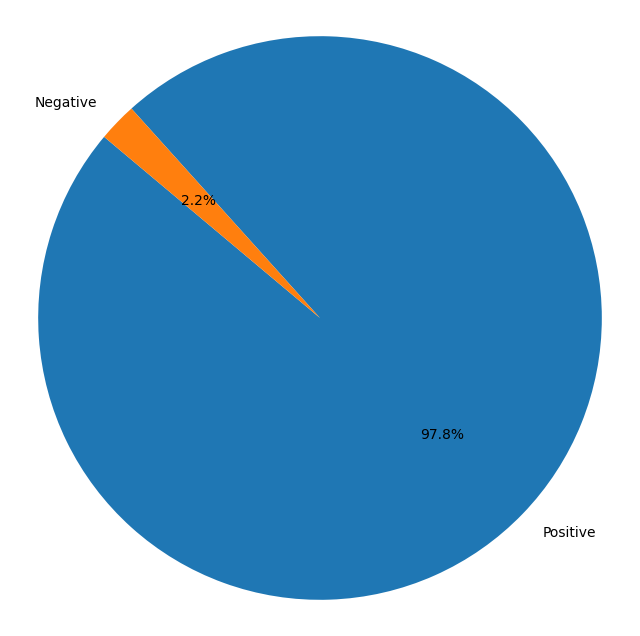

In [12]:
label_count = senti_df['label'].value_counts()
poss = label_count.get('POSITIVE')
negs = label_count.get('NEGATIVE')

result = [poss, negs]
labels = ["Positive", "Negative"]

pie_chart(result, labels)

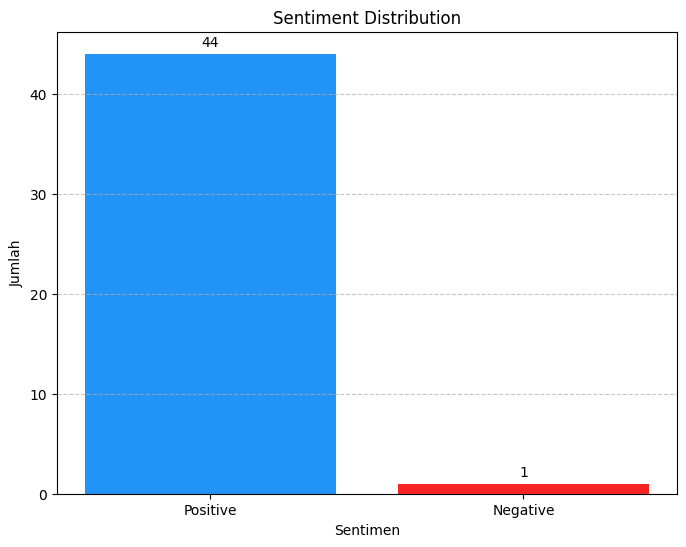

In [13]:
show_bar_chart(
    ["Positive", "Negative"],
    [poss, negs],
    "Sentiment Distribution"
)

### 2) rating prediction

In [14]:
# Removing neutral sentiments because they aren't affecting
# the positivity or negativity
pos_neg_df = senti_df[senti_df["label"] != "NEUTRAL"]
pos_neg_df.head()

,review,label,score
0,"Tempatnya strategis, pengajarnya juga berkuali...",POSITIVE,0.998759
1,"Selain pengajarnya yg ramah, tempatnya jg nyam...",POSITIVE,0.999244
2,Tempat belajar terfavorit dan pastinya nyaman ...,POSITIVE,0.999469
3,Tempat terbaik buat anak2 belajar bahasa inggr...,POSITIVE,0.999351
4,"Tempatnya bagus, Nyaman buat anak-anak belajar...",POSITIVE,0.999178


In [15]:
pos_df = pd.DataFrame({
    "review": pos_neg_df["review"],
    "positivity": senti_df.apply(lambda row: 1 - row['score'] if row['label'] == 'NEGATIVE' else row['score'], axis=1)
})

pos_df.head()

,review,positivity
0,"Tempatnya strategis, pengajarnya juga berkuali...",0.998759
1,"Selain pengajarnya yg ramah, tempatnya jg nyam...",0.999244
2,Tempat belajar terfavorit dan pastinya nyaman ...,0.999469
3,Tempat terbaik buat anak2 belajar bahasa inggr...,0.999351
4,"Tempatnya bagus, Nyaman buat anak-anak belajar...",0.999178


In [16]:
positivity = pos_df["positivity"]
normalized_scores = [(score * 4) + 1 for score in (positivity)]

In [17]:
import numpy as np

def hist(normalized_scores):
    bin_width = 0.5
    num_bins = int((max(normalized_scores) - min(normalized_scores)) / bin_width)

    plt.hist(normalized_scores, bins=num_bins, edgecolor='black')
    plt.xlabel('Normalized Scores')
    plt.ylabel('Frequency')
    plt.title(f'Average Rating: {np.mean(normalized_scores):.2f}')
    plt.show()

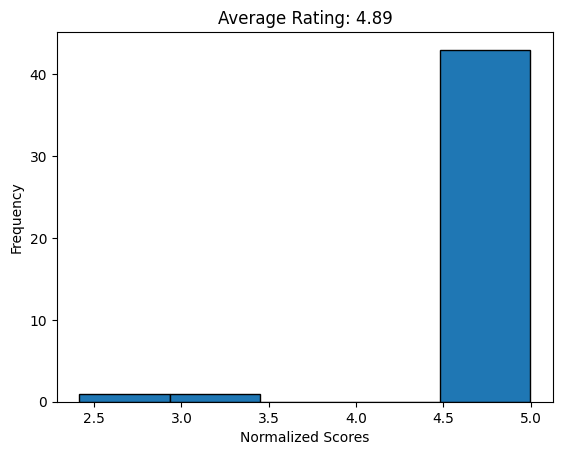

In [18]:
hist(normalized_scores)

# 2. Topic Modelling

In [19]:
import pyLDAvis
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from nlp_id.stopword import StopWord
from gensim.parsing.preprocessing import preprocess_string
import pyLDAvis.gensim_models as gensimvis

## a. Preprocessing

In [20]:
documents = reviews

# Remove Indonesian stop words
stopword = StopWord()
stop_removed = [stopword.remove_stopword(text) for text in reviews]

# Preprocess text
processed_docs = [preprocess_string(doc) for doc in stop_removed]

# Create dictionary
dictionary = corpora.Dictionary(processed_docs)

# Create bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## b. Training and Visualization

In [21]:
# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=100)

In [22]:
# Visualize topics
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

## c. Coherence Score

In [23]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4225484880419623


# 3. Word Cloud

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nlp_id.tokenizer import Tokenizer

## a. Preprocessing

In [25]:
def preprocess_text(reviews):
    tokenizer = Tokenizer()
    stopword = StopWord()
    stop_words = stopword.get_stopword()
    
    text = " ".join(reviews)
    tokens = [tokenizer.tokenize(text.lower())][0]
    tokens = [token for token in tokens if token.isalpha()
              and token not in stop_words]
    return tokens

In [26]:
tokens = preprocess_text(reviews)

In [27]:
analyzed_tokens = analyze_sentiment(tokens)

In [28]:
token_sentiment = []
for i in range(len(tokens)):
    token_sentiment_map = {
        "token": tokens[i],
        "sentiment": analyzed_tokens[i]["label"]
    }
    token_sentiment.append(token_sentiment_map)

In [29]:
positive_tokens = [mapping["token"] for mapping in token_sentiment if mapping["sentiment"] == "positive"]
negative_tokens = [mapping["token"] for mapping in token_sentiment if mapping["sentiment"] == "negative"]

In [30]:
from collections import Counter

top_5_tokens = Counter(tokens).most_common(5)
tokens_5 = [token[0] for token in top_5_tokens]
counts_5 = [token[1] for token in top_5_tokens]

## b. Visualization

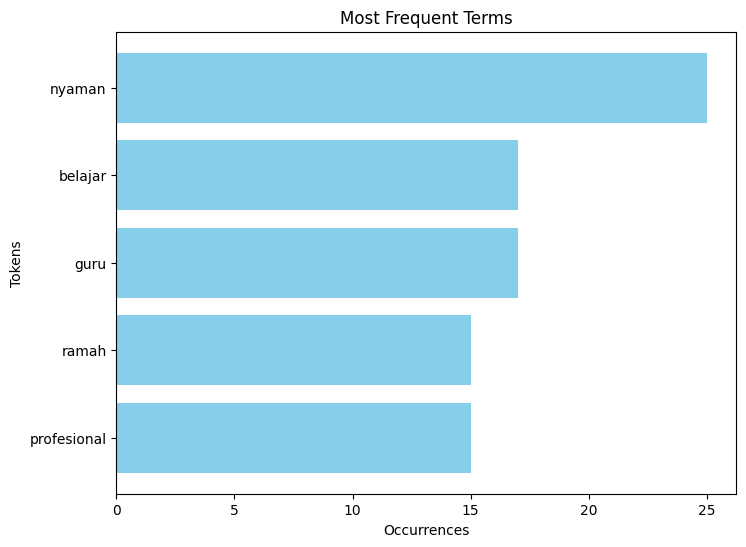

In [31]:
plt.figure(figsize=(8, 6))
plt.barh(tokens_5, counts_5, color='skyblue')
plt.xlabel('Occurrences')
plt.ylabel('Tokens')
plt.title('Most Frequent Terms')
plt.gca().invert_yaxis()
plt.show()

In [32]:
def generate_wordcloud(words):
    # Generate WordCloud for adjectives
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white').generate(words)

    # Display the WordCloud using matplotlib
    _, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

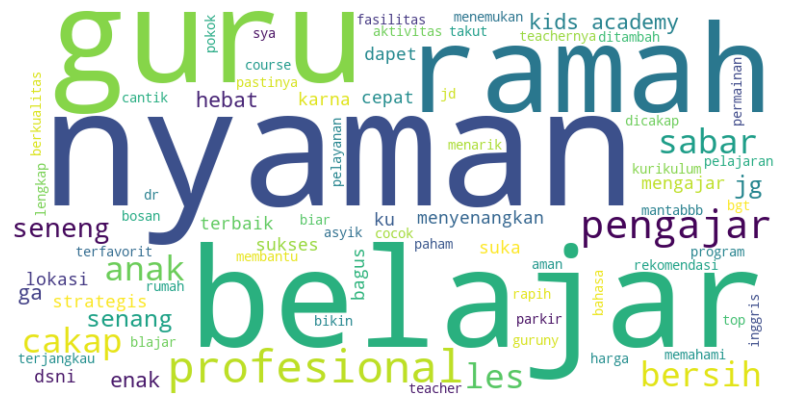

In [33]:
text = " ".join(tokens)
generate_wordcloud(text)